# An example of using candex with source netCDF files in irregualr shape 
## Remapping of SCDNA to subbasins of South Saskatchewan River at Medicine Hat, Alberta, Canada.

       index   LATITUDE   LONGITUDE                     geometry
0          4  48.939999 -123.739998  POINT (-123.74000 48.94000)
1          6  48.520000 -123.370003  POINT (-123.37000 48.52000)
2          8  48.820000 -124.129997  POINT (-124.13000 48.82000)
3          9  48.830002 -124.050003  POINT (-124.05000 48.83000)
4         10  48.770000 -123.680000  POINT (-123.68000 48.77000)
...      ...        ...         ...                          ...
19599  27271  59.049999 -158.516693  POINT (-158.51669 59.05000)
19600  27272  56.247200 -134.644699  POINT (-134.64470 56.24720)
19601  27273  20.962500 -156.675293  POINT (-156.67529 20.96250)
19602  27274  47.508301 -115.946098  POINT (-115.94610 47.50830)
19603  27275  21.316700 -158.066696  POINT (-158.06670 21.31670)

[19604 rows x 4 columns]


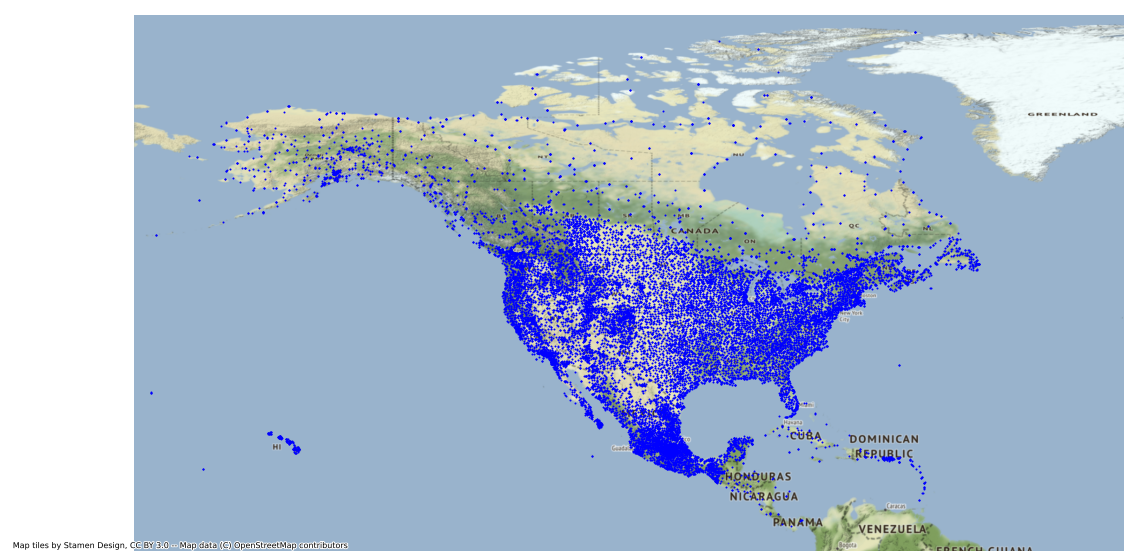

In [10]:
import pandas as pd
import numpy as np
import xarray as xr
from   shapely.geometry import Point, Polygon
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import shapefile
import geovoronoi
import requests

ds = xr.open_dataset('/Users/shg096/Desktop/SCDNA_v1.1.nc')
name_of_varibale = 'tmin'

df = pd.DataFrame()
df['values'] = np.array (ds[name_of_varibale][:,1400])
df['LATITUDE'] = np.array(ds.LLE[0,:])
df['LONGITUDE'] = np.array(ds.LLE[1,:])
df = df.dropna() # remove the nan values from the data frame
df = df.reset_index()

#
points = df
points = points.drop(columns = ['values'])


# the columns of the DataFrame
points['geometry'] = points.apply(lambda row: Point(row.LONGITUDE, row.LATITUDE ), axis=1) # set the geometry
points  = gpd.GeoDataFrame(points) # pass this to a geopandas dataframe
print(points)
points.to_file('point.shp')


# boundary = gpd.read_file(“data/uppsala.shp”)
fig, ax = plt.subplots(figsize=(20, 10))
points.plot(ax=ax, color='blue', markersize = 1)
ax.axis('off')
plt.axis('equal')
ctx.add_basemap(ax, zoom=4, crs='EPSG:4326')
plt.show()



In [11]:

parts = []
with shapefile.Writer('test.shp') as w:
    w.autoBalance = 1 # turn on function that keeps file stable if number of shapes and records don't line up
    w.field("ID_s",'N') # create (N)umerical attribute fields, integer
    w.field("lat_s",'F',decimal=4) # float with 4 decimals
    w.field("lon_s",'F',decimal=4) # float with 4 decimals

    # creating the polygon given the lat and lon
    parts.append([ (-180,  0),\
                   (-180, 90), \
                   (0   , 90), \
                   (0   ,  0), \
                   (-180,  0)])

    # store polygon
    w.poly(parts)

    # update records/fields for the polygon
    w.record(1, 1, 1)

shp_source = gpd.read_file('test.shp')
shp_source = shp_source.set_crs("EPSG:4326") # set the projection to WGS84


In [12]:
# import numpy as np
# import geopandas as gpd
# import contextily as ctx
# import matplotlib.pyplot as plt
# from shapely.ops import cascaded_union
# from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
# from geovoronoi import voronoi_regions_from_coords, points_to_coords


import geovoronoi


points = gpd.read_file('point.shp')
print(points)

coords = geovoronoi.points_to_coords(points.geometry)
boundary = gpd.read_file('test.shp')

poly_shapes, ID = \
geovoronoi.voronoi_regions_from_coords(coords, boundary.iloc[0].geometry)



       index   LATITUDE   LONGITUDE                     geometry
0          4  48.939999 -123.739998  POINT (-123.74000 48.94000)
1          6  48.520000 -123.370003  POINT (-123.37000 48.52000)
2          8  48.820000 -124.129997  POINT (-124.13000 48.82000)
3          9  48.830002 -124.050003  POINT (-124.05000 48.83000)
4         10  48.770000 -123.680000  POINT (-123.68000 48.77000)
...      ...        ...         ...                          ...
19599  27271  59.049999 -158.516693  POINT (-158.51669 59.05000)
19600  27272  56.247200 -134.644699  POINT (-134.64470 56.24720)
19601  27273  20.962500 -156.675293  POINT (-156.67529 20.96250)
19602  27274  47.508301 -115.946098  POINT (-115.94610 47.50830)
19603  27275  21.316700 -158.066696  POINT (-158.06670 21.31670)

[19604 rows x 4 columns]


In [13]:
print(len(poly_shapes))

19590


In [ ]:
newdata = gpd.GeoDataFrame()
newdata['geometry'] = None
newdata['ID'] = None
newdata['LATITUDE'] = None
newdata['LONGITUDE'] = None


for i in np.arange(len(poly_shapes)):
    print(i)
    poly = Polygon(Polygon(poly_shapes[i]))
    newdata.loc[i, 'geometry'] = poly
    newdata.loc[i, 'ID']      = ID[i][0]
    newdata.loc[i, 'LATITUDE'] = points.iloc[pts[i][0]].LATITUDE
    newdata.loc[i, 'LONGITUDE']= points.iloc[pts[i][0]].LONGITUDE

# Let's see what we have now
print(newdata)
newdata = newdata.set_crs("EPSG:4326")

newdata.to_file('Thissen.shp')



<xarray.Dataset>
Dimensions:    (lle: 3, nchar: 13, nday: 14610, nsf: 3, nstn: 27276)
Dimensions without coordinates: lle, nchar, nday, nsf, nstn
Data variables:
    ID         (nchar, nstn) |S1 ...
    LLE        (lle, nstn) float32 ...
    date       (nday) int32 ...
    sflag      (nsf, nstn) |S1 ...
    prcp       (nstn, nday) float32 ...
    prcp_flag  (nstn, nday) float64 ...
    prcp_kge   (nstn) float32 ...
    tmin       (nstn, nday) float32 ...
    tmin_flag  (nstn, nday) float64 ...
    tmin_kge   (nstn) float32 ...
    tmax       (nstn, nday) float32 ...
    tmax_flag  (nstn, nday) float64 ...
    tmax_kge   (nstn) float32 ...


(10.0, 80.0)

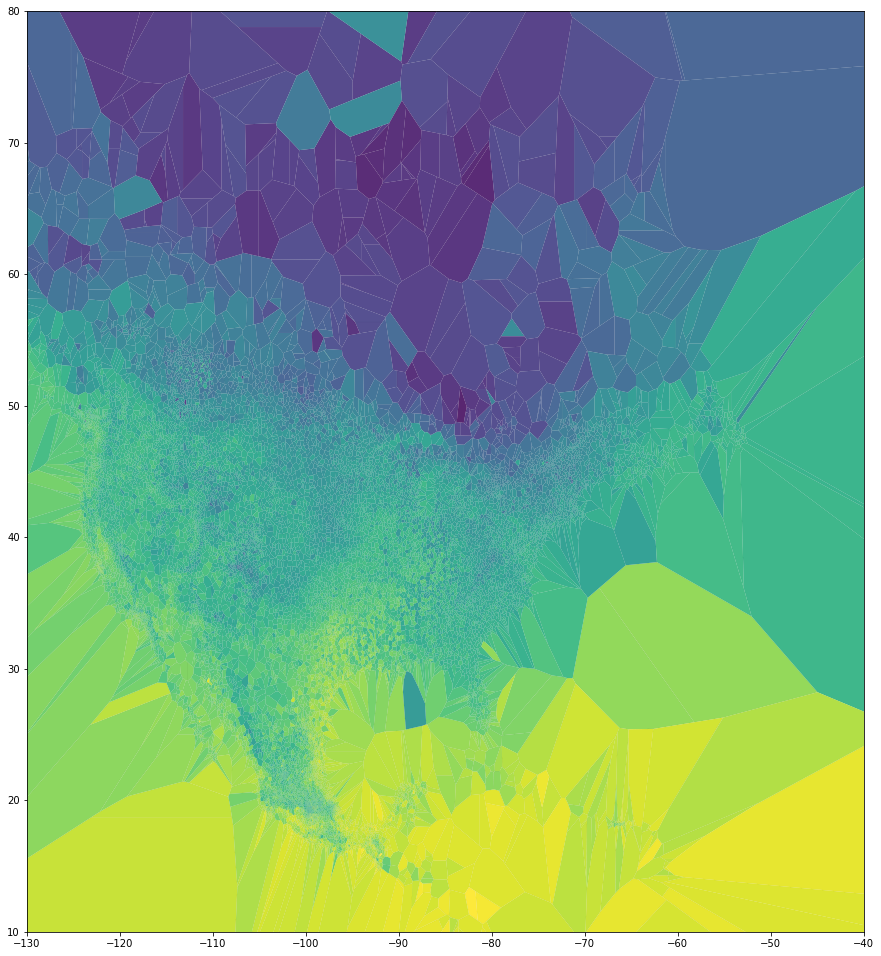

In [9]:



ds = xr.open_dataset('/Users/shg096/Desktop/SCDNA_v1.1.nc')
print(ds)

df = pd.DataFrame()

temp = np.array (ds.tmin [:,1500])
temp = temp[~np.isnan(temp)]

newdata = gpd.read_file('Thissen.shp')

idx = np.array(newdata.ID).astype(int)

newdata['values'] = temp[idx]


newdata['LONGITUDE'] = newdata['LONGITUDE'].astype(float)
newdata['LATITUDE'] = newdata['LATITUDE'].astype(float)

newdata_slice = newdata

# newdata_slice = newdata [newdata['LONGITUDE']>-120]
# newdata_slice = newdata_slice [newdata_slice['LONGITUDE']<-108]
# newdata_slice = newdata_slice [newdata_slice['LATITUDE']>48]
# newdata_slice = newdata_slice [newdata_slice['LATITUDE']<52]

ax  = newdata_slice.plot(column="values", edgecolor='k',linewidth = 0.01 , figsize=(15,30),\
                         alpha=0.9)

#ctx.add_basemap(ax, zoom=2, crs='EPSG:4326')
#plt.scatter (points['LONGITUDE'],points['LATITUDE'])

plt.xlim([-130,-40])
plt.ylim([10,80])


# points = gpd.read_file('point.shp')
# print(points)
# ax1 = plt.scatter(newdata.stn_lon, newdata.stn_lat)

# ctx.add_basemap(ax= axes, zoom=12)
# ctx.add_basemap(axes, zoom=3)

#points.plot(ax = axes)

#plt.scatter (points['LONGITUDE'],points['LATITUDE'])

In [ ]:
import requests

print('Beginning file download with requests')

url = 'https://zenodo.org/record/3953310/files/SCDNA_v1.1.nc4?download=1'
r = requests.get(url)

with open('/Users/shg096/Desktop/SCDNA_v1.1_test.nc', 'wb') as f:
    f.write(r.content)

# Retrieve HTTP meta-data
print(r.status_code)
print(r.headers['content-type'])
print(r.encoding)


In [1]:
import numpy as np
import xarray as xr

ds = xr.open_dataset('/Users/shg096/Desktop/SCDNA_v1.1.nc')

ds = ds.drop(['tmax','tmax_flag', 'tmax_kge', 'prcp', 'prcp_flag','prcp_kge', 'tmin_flag', 'tmin_kge'])


ds['LATITUDE'] = ds.LLE[0,:]
ds['LONGITUDE'] = ds.LLE[1,:]

import netCDF4      as nc4

with nc4.Dataset('time.nc', "w", format="NETCDF4") as ncid: # creating the NetCDF file
    
    dimid_T = ncid.createDimension('nday', None)   # unlimited dimensiton

    # Variable time
    time_varid = ncid.createVariable('time', 'i4', ('nday', ))
    # Attributes
    time_varid.long_name = 'time'
    time_varid.units = 'days since 1979-01-01'  # e.g. 'days since 2000-01-01 00:00' should change accordingly
    time_varid.calendar = 'standard'
    time_varid.standard_name = 'time'
    time_varid.axis = 'T'
    time_varid[:] = np.arange(14610)


ds_time = xr.open_dataset('time.nc')

# days = pd.date_range(start='1/1/1979', end='31/12/2018')
# attrs = {"units": "days since 1979-01-01"}
# ds_time = xr.Dataset(({"time": ("nday", days)}))
# ds_time.to_netcdf('time.nc'); ds_time = xr.Dataset('time.nc')

ds = xr.merge([ds, ds_time])

print(ds)

ds1 = ds.rename({'nday':'time'})

ds1.to_netcdf('/Users/shg096/Desktop/SCDNA_v1.1_latlon1.nc')

ds2 = xr.open_dataset('/Users/shg096/Desktop/SCDNA_v1.1_latlon1.nc')

print(ds)

ds2 = ds2.set_coords('time')
print(ds1)

ds2.to_netcdf('/Users/shg096/Desktop/SCDNA_v1.1_latlon2.nc')

#ds.tmin[:,1].plot()

# ds.to_netcdf('/Users/shg096/Desktop/SCDNA_v1.1_latlon.nc')




<xarray.Dataset>
Dimensions:    (lle: 3, nchar: 13, nday: 14610, nsf: 3, nstn: 27276)
Dimensions without coordinates: lle, nchar, nday, nsf, nstn
Data variables:
    ID         (nchar, nstn) |S1 ...
    LLE        (lle, nstn) float32 ...
    date       (nday) int32 ...
    sflag      (nsf, nstn) |S1 ...
    tmin       (nstn, nday) float32 ...
    LATITUDE   (nstn) float32 ...
    LONGITUDE  (nstn) float32 ...
    time       (nday) datetime64[ns] ...
<xarray.Dataset>
Dimensions:    (lle: 3, nchar: 13, nday: 14610, nsf: 3, nstn: 27276)
Dimensions without coordinates: lle, nchar, nday, nsf, nstn
Data variables:
    ID         (nchar, nstn) |S1 ...
    LLE        (lle, nstn) float32 ...
    date       (nday) int32 ...
    sflag      (nsf, nstn) |S1 ...
    tmin       (nstn, nday) float32 ...
    LATITUDE   (nstn) float32 ...
    LONGITUDE  (nstn) float32 ...
    time       (nday) datetime64[ns] ...
<xarray.Dataset>
Dimensions:    (lle: 3, nchar: 13, nsf: 3, nstn: 27276, time: 14610)
Dimens

In [8]:
import xarray as xr
ds = xr.open_dataset('/Users/shg096/Desktop/SCDNA_v1.1_latlon2.nc')


print(ds)

ds = ds.sel(time=slice("2000",'2000'))

print(ds)

ds.to_netcdf('/Users/shg096/Desktop/SCDNA_v1.1_latlon3.nc')



<xarray.Dataset>
Dimensions:    (lle: 3, nchar: 13, nsf: 3, nstn: 27276, time: 14610)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2018-12-31
Dimensions without coordinates: lle, nchar, nsf, nstn
Data variables:
    ID         (nchar, nstn) |S1 ...
    LLE        (lle, nstn) float32 ...
    date       (time) int32 ...
    sflag      (nsf, nstn) |S1 ...
    tmin       (nstn, time) float32 ...
    LATITUDE   (nstn) float32 ...
    LONGITUDE  (nstn) float32 ...
<xarray.Dataset>
Dimensions:    (lle: 3, nchar: 13, nsf: 3, nstn: 27276, time: 366)
Coordinates:
  * time       (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2000-12-31
Dimensions without coordinates: lle, nchar, nsf, nstn
Data variables:
    ID         (nchar, nstn) |S1 ...
    LLE        (lle, nstn) float32 ...
    date       (time) int32 ...
    sflag      (nsf, nstn) |S1 ...
    tmin       (nstn, time) float32 ...
    LATITUDE   (nstn) float32 ...
    LONGITUDE  (nstn) float32 ...


In [1]:
# loading candex
from candex import candex

# initializing candex object
cndx = candex()

# specifying candex needed arguments
cndx.name_of_case             = 'SCDNA_Medicine_Hat' # name of the case
cndx.temporary_candex_folder  = '../temporary/' # temporary path that the candex generated GIS files and rempped file will be saved
cndx.name_of_target_shp       = '../data/target_shapefiles/South_Saskatchewan_MedicineHat.shp' # target shapefile that the source will be remmaped to
cndx.name_of_nc_files         = '/Users/shg096/Desktop/SCDNA_v1.1_latlon3.nc' # name of netCDF file(s) if multiple you can specify with *
cndx.name_of_var_name         = ['tmin'] # name of variables from source netCDF file(s) to be remapped
cndx.name_of_var_lon          = 'LONGITUDE' # name of varibale longitude in source netCDF files 
cndx.name_of_var_lat          = 'LATITUDE' # name of variable latitude in source netCDF files
cndx.name_of_var_time         = 'time' # name of varibale time in source netCDF file
cndx.name_of_shp_for_nc_files = 'Thissen.shp'
cndx.name_of_field_target_lat_shp_for_nc_files  =  'LATITUDE' # name_of_nc_files
cndx.name_of_field_target_lon_shp_for_nc_files  =  'LONGITUDE'
cndx.name_of_nc_output_folder = '../output/' # location where the remapped netCDF file will be saved
cndx.format_list              =  ['f4']#,'f4'] # format of the varibales to be saved with
cndx.fill_value_list          = ['-9999.00']#,'-9999.00'] # missing values for the varibales
# cndx.name_of_remap_file        = '../temporary/ERA5_Medicine_Hat_remapping.csv' # if uncommneted candex will use this and skip GIS taskes

# execute candex
cndx.run_candex()





no  author name is provide and the author name is changes to (author name)
candex detects that target shapefile is in WGS84 (epsg:4326)
candex detects that no fields are provided for ID, lat, lon and will assign those by itself


/Users/shg096/Desktop/candex_newgen/candex/candex.py:128: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp['lat_t'] = shp.centroid.y # centroid lat from target
/Users/shg096/Desktop/candex_newgen/candex/candex.py:129: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp['lon_t'] = shp.centroid.x # centroid lon from target


candex will save standard shapefile for candex claculation as:
../temporary/SCDNA_Medicine_Hat_target_shapefile.shp
candex detects that the varibales from the netCDF files are identicalin dimensions of the varibales and latitude and longitude
candex detects that all the varibales have dimensions of:
['nstn', 'time']
candex detects that the longitude varibales has dimensions of:
['nstn']
candex detects that the latitude varibales has dimensions of:
['nstn']
candex detects case 3 - irregular lat/lon; shapefile should be provided
[48.87   48.6    48.58   ... 20.9625 47.5083 21.3167] [-123.28   -123.47   -123.42   ... -156.6753 -115.9461 -158.0667]
candex detects that no varibale for ID of the source netCDF file; an arbitatiry ID will be provided
candex decides the netCDF file has longtitude values of -180 to 180; creating the extended
candex saved the expanded shapefile at:
../temporary/SCDNA_Medicine_Hat_source_shapefile_expanded.shp
candex detects that source shapefile is in WGS84 (epsg

/Users/shg096/Desktop/candex_newgen/candex/candex.py:637: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp_1['AS1'] = shp_1.area
/Users/shg096/Desktop/candex_newgen/candex/candex.py:641: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp_2['AS2'] = shp_2.area
/Users/shg096/Desktop/candex_newgen/candex/candex.py:736: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  pairs = gpd.GeoDataFrame(nei, columns=['idx1','idx2'], crs=df1.crs)
/Users/shg096/Desktop/candex_newgen/candex/candex.py:740: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  pairs = gpd.Ge

Remapping /Users/shg096/Desktop/SCDNA_v1.1_latlon3.nc to ../output/SCDNA_Medicine_Hat_remapped_2000-01-01-00-00-00.nc
Started at date and time 2021-02-13 23:25:25.868633
Ended   at date and time 2021-02-13 23:25:39.043139


<xarray.Dataset>
Dimensions:    (ID: 417, time: 366)
Coordinates:
  * time       (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2000-12-31
  * ID         (ID) float64 1.0 2.0 3.0 4.0 5.0 ... 414.0 415.0 416.0 417.0
Data variables:
    latitude   (ID) float64 ...
    longitude  (ID) float64 ...
    tmin       (time, ID) float32 ...
Attributes:
    Conventions:  CF-1.6
    License:      The data were written by 
    history:      Created Sat Feb 13 23:25:25 2021
    source:       Case: SCDNA_Medicine_Hat; remapped by script from library o...


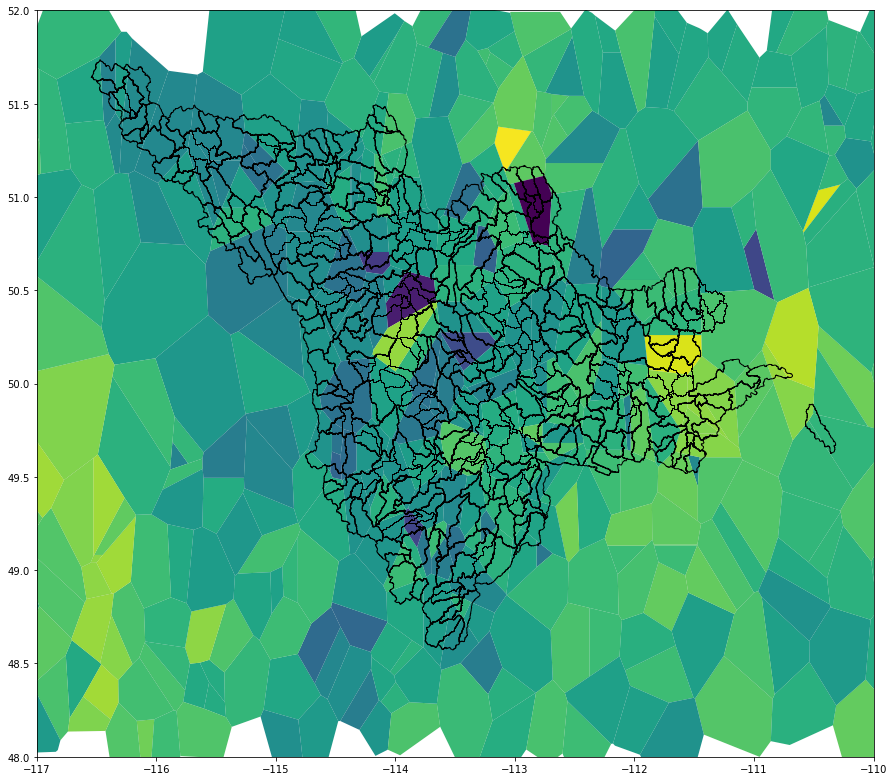

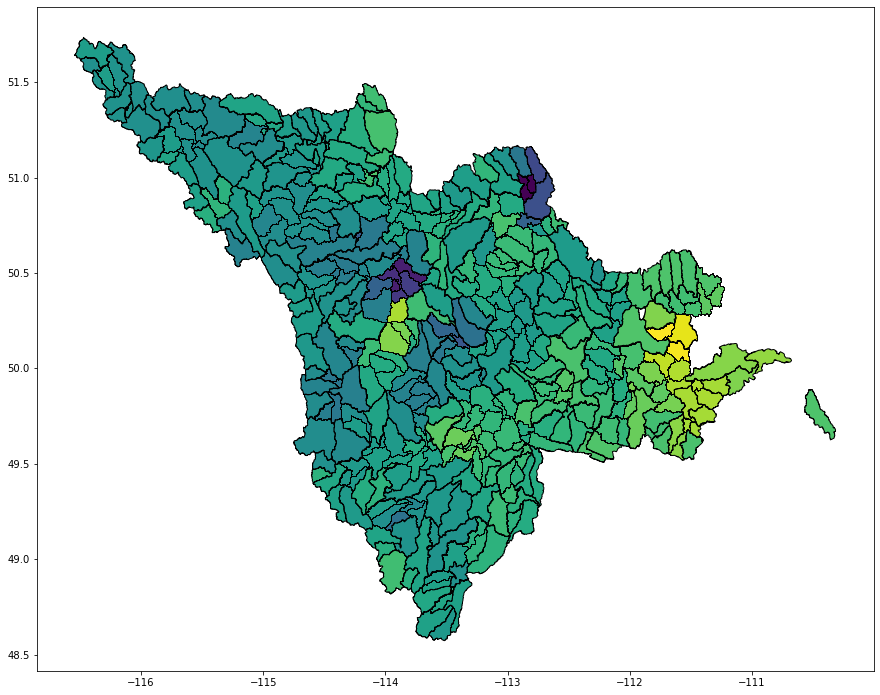

In [8]:
import glob
import xarray as xr
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

nc_name = sorted(glob.glob(cndx.name_of_nc_files))
ds = xr.open_dataset(nc_name[0])


df = pd.DataFrame()

temp = np.array (ds.tmin [:,300])
temp = temp[~np.isnan(temp)]

newdata = gpd.read_file('Thissen.shp')

idx = np.array(newdata.ID).astype(int)

newdata['values'] = temp[idx]


newdata['LONGITUDE'] = newdata['LONGITUDE'].astype(float)
newdata['LATITUDE'] = newdata['LATITUDE'].astype(float)

newdata_slice = newdata

newdata_slice = newdata [newdata['LONGITUDE']>-120]
newdata_slice = newdata_slice [newdata_slice['LONGITUDE']<-108]
newdata_slice = newdata_slice [newdata_slice['LATITUDE']>48]
newdata_slice = newdata_slice [newdata_slice['LATITUDE']<52]

ax  = newdata_slice.plot(column="values", edgecolor='k',linewidth = 0.01 , figsize=(15,30))

shp_target = gpd.read_file(cndx.temporary_candex_folder+ cndx.name_of_case + '_target_shapefile.shp') # load the target shapefile

shp_target.geometry.boundary.plot(color=None, edgecolor='k',linewidth = 1 , figsize=(15,30),ax=ax)

plt.xlim([-117, -110])
plt.ylim([  48,   52])

plt.savefig('case3A.png')

#ctx.add_basemap(ax, zoom=2, crs='EPSG:4326')
#plt.scatter (points['LONGITUDE'],points['LATITUDE'])



nc_names = sorted(glob.glob (cndx.name_of_nc_output_folder + cndx.name_of_case + '*.nc'))
ds       = xr.open_dataset(nc_names[0]) # the first netcdf file

print(ds)

temp = np.array (ds.tmin [:,300])

shp = gpd.read_file('Thissen.shp')



values   = ds.tmin [300,:] # the first time frame of the first 
IDs      = ds.ID [:] # get the ID
# create a data frame for the model simulation
df = pd.DataFrame()
df ['value'] = values
df ['ID_t']    = IDs  # .astype(int)
df = df.sort_values (by = 'ID_t')
# load the shape file target that is generated by candex (with consistent IDs)
shp_target = gpd.read_file(cndx.temporary_candex_folder+ cndx.name_of_case + '_target_shapefile.shp') # load the target shapefile
shp_target ['ID_t'] = shp_target ['ID_t'].astype(float)
shp_target = shp_target.sort_values(by='ID_t')# sort on values
shp_target = pd.merge_asof(shp_target, df, on='ID_t', direction='nearest')
shp_target = shp_target.set_geometry('geometry') #bring back the geometry filed; pd to gpd

# plotting
f, axes = plt.subplots(1,1,figsize=(15,15))
shp_target.plot(column= 'value', edgecolor='k',linewidth = 1, ax = axes )#, legend=True)

plt.savefig('case3B.png')
